<a href="https://colab.research.google.com/github/Rodrig0/MVP4/blob/main/Construcao_Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise comparativa para a seleção do melhor modelo de Machine Learning para prever sobreviventes do naufrágio do Titanic






In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from joblib import dump

## Carga do Dataset

In [ ]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/Rodrig0-Viana/MVP-4/main/Titanic.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [ ]:
# Verificando a cardinalidade dos dados
dataset.nunique().sort_values(ascending=False)

PassengerId    891
Name           891
Ticket         681
Fare           248
Cabin          147
Age             88
SibSp            7
Parch            7
Pclass           3
Embarked         3
Sex              2
Survived         2
dtype: int64

In [ ]:
# Para obtermos melhores resultados com a predição, eliminamos as colunas com alta cardinalidade,
# bem como a 'PassengerId´, que não irá agregar para as predições

dataset = dataset.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)


In [ ]:
# Verificar as colunas que possuem valores vazios
dataset.isnull().sum().sort_values(ascending=False).head(9)

Age         177
Embarked      2
Pclass        0
Sex           0
SibSp         0
Parch         0
Fare          0
Survived      0
dtype: int64

In [ ]:
# Substituindo os campos vazios da coluna 'Age' pela média das idades
dataset.loc[dataset.Age.isnull(), 'Age'] = dataset.Age.mean()
dataset['Age'] = dataset['Age'].round().astype(int)


In [ ]:
# Substituindo os campos vazios da coluna 'Embarked' pela moda dos valores
dataset.loc[dataset.Embarked.isnull(),'Embarked'] = dataset.Embarked.mode()[0]

In [ ]:
# Tratando a coluna 'Sex' e criando uma nova coluna, que se chamará 'BinarySex',
# a qual receberá o valor 1, caso o gênero seja masculino, e o valor 0, caso seja feminino

dataset['BinarySex'] = dataset.Sex.apply(lambda x: 1 if x== 'male'else 0)

# Conferindo a modificação
dataset[['Sex', 'BinarySex']].value_counts()

Sex     BinarySex
male    1            577
female  0            314
dtype: int64

In [ ]:
# Tratando a coluna 'Embarked' criando uma nova coluna para cada um dos rótulos da coluna original
ohe = OneHotEncoder(handle_unknown='ignore', dtype = 'int32')
ohe = ohe.fit(dataset[['Embarked']])
ohe.transform(dataset[['Embarked']]).toarray()

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]], dtype=int32)

In [ ]:
# Transformando os resultados obtidos no tratamento da coluna 'Embarked' em um DataFrame
ohe_df = pd.DataFrame(ohe.transform(dataset[['Embarked']]).toarray(), columns=ohe.get_feature_names_out())

#Adicionando nova coluna
dataset = pd.concat([dataset,ohe_df], axis=1)

In [ ]:
# Conferindo a modificação
dataset[['Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].value_counts()

Embarked  Embarked_C  Embarked_Q  Embarked_S
S         0           0           1             646
C         1           0           0             168
Q         0           1           0              77
dtype: int64

In [ ]:
# Eliminando as colunas 'Sex'e 'Embarked', já tratadas
dataset = dataset.drop(['Sex', 'Embarked'], axis=1)

In [ ]:
dataset.head()

,Pclass,Age,SibSp,Parch,Fare,Survived,BinarySex,Embarked_C,Embarked_Q,Embarked_S
0,3,22,1,0,7.2500,0,1,0,0,1
1,1,38,1,0,71.2833,1,0,1,0,0
2,3,26,0,0,7.9250,1,0,0,0,1
3,1,35,1,0,53.1000,1,0,0,0,1
4,3,35,0,0,8.0500,0,1,0,0,1


In [ ]:
# Reorganizando as posições das colunas
nova_ordem_colunas = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'BinarySex', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Survived']
dataset = dataset[nova_ordem_colunas]



## Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:9]
y = array[:,9]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

df = pd.DataFrame(X_train)
df.head()


,0,1,2,3,4,5,6,7,8
0,3.0,30.0,0.0,0.0,24.15,1.0,0.0,1.0,0.0
1,3.0,24.0,0.0,0.0,8.05,1.0,0.0,0.0,1.0
2,3.0,30.0,0.0,0.0,8.05,1.0,0.0,0.0,1.0
3,1.0,22.0,0.0,0.0,151.55,0.0,0.0,0.0,1.0
4,1.0,37.0,1.0,0.0,53.10,1.0,0.0,0.0,1.0


## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.703502 (0.057102)
CART: 0.773905 (0.043621)
NB: 0.780810 (0.039814)
SVM: 0.679734 (0.036909)


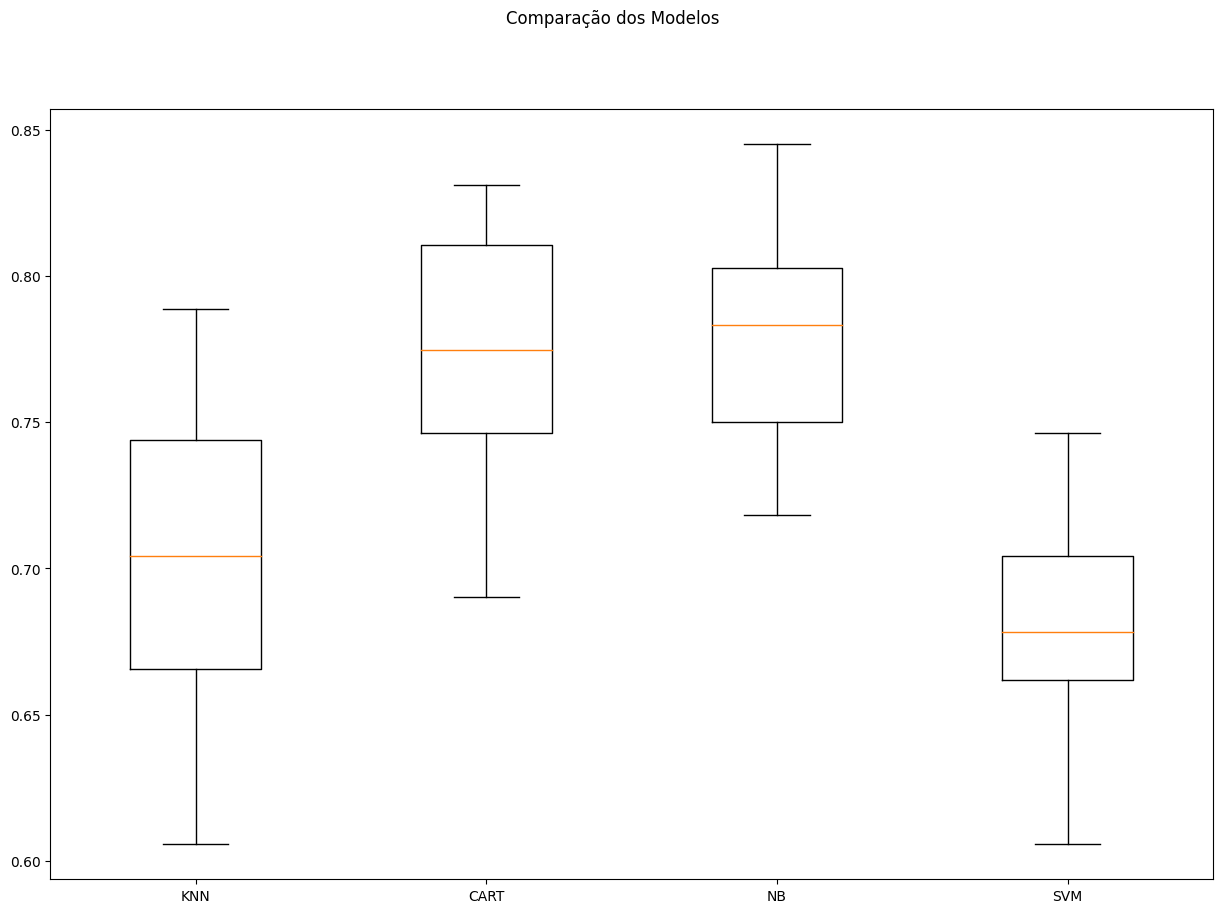

In [ ]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.704 (0.057)
CART-orig: 0.774 (0.044)
NB-orig: 0.781 (0.040)
SVM-orig: 0.680 (0.037)
KNN-padr: 0.805 (0.040)
CART-padr: 0.779 (0.050)
NB-padr: 0.781 (0.040)
SVM-padr: 0.812 (0.032)
KNN-norm: 0.806 (0.034)
CART-norm: 0.768 (0.053)
NB-norm: 0.781 (0.040)
SVM-norm: 0.820 (0.039)


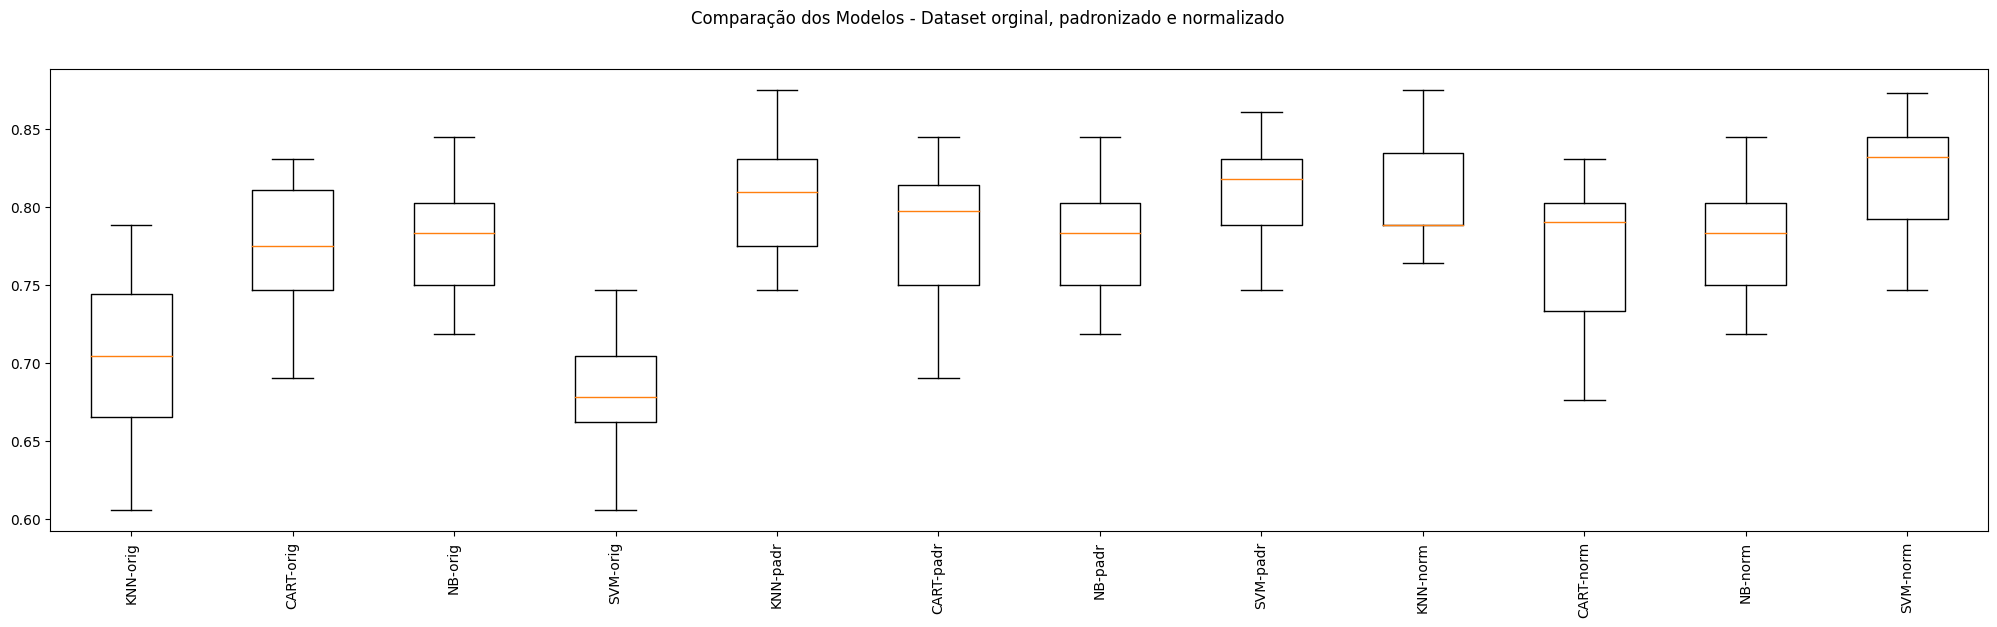

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [ ]:
# Tuning do SVM

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

param_grid = {
    'SVM__C': [0.1, 0.5, 1.1, 1.5, 2.0],
    'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}


# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Modelo: SVM-orig - Melhor: 0.792097 usando {'SVM__C': 0.1, 'SVM__kernel': 'linear'}
Modelo: SVM-padr - Melhor: 0.818740 usando {'SVM__C': 1.5, 'SVM__kernel': 'rbf'}
Modelo: SVM-norm - Melhor: 0.820168 usando {'SVM__C': 0.5, 'SVM__kernel': 'rbf'}


## Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = SVC(C = 0.5, kernel = 'rbf')
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.8268156424581006


In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

SVC(C=0.5)

## Simulando a aplicação do modelo em dados não vistos

In [ ]:
# Novos dados - não sabemos a classe!
data = {'pclass':  [1, 2, 1, 3, 2],
        'age': [12, 7, 9, 35, 40],
        'sibsp': [1, 0, 0, 0, 1 ],
        'parch': [1, 0, 0, 0, 3],
        'fare': [5.0000, 45.0000, 90.0000, 20.000, 70.000],
        'sex': [1, 0, 0, 1, 0],
        'embarkedc': [1, 0, 0, 1,0],
        'embarkedq': [0, 1, 0, 0,0],
        'embarkeds': [0, 0, 1, 0,1],
        }

atributos = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarkedc', 'embarkedq', 'embarkeds',]
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:9].astype(float)


# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-1.56610693 -1.36638832  0.43279337  0.76762988 -0.54774822  0.73769513
   2.0745051  -0.30756234 -1.62380254]
 [-0.36936484 -1.7511952  -0.4745452  -0.47367361  0.25763927 -1.35557354
  -0.48204268  3.25137334 -1.62380254]
 [-1.56610693 -1.59727245 -0.4745452  -0.47367361  1.16370019 -1.35557354
  -0.48204268 -0.30756234  0.61583843]
 [ 0.82737724  0.40372331 -0.4745452  -0.47367361 -0.24572791  0.73769513
   2.0745051  -0.30756234 -1.62380254]
 [-0.36936484  0.78853019  0.43279337  3.25023685  0.76100645 -1.35557354
  -0.48204268 -0.30756234  0.61583843]]


In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 1. 1. 0. 1.]


In [ ]:
# Salvando o modelo treinado em um arquivo
pickle_out = open('classificador.pkl', 'wb')
pickle.dump(model, pickle_out)
pickle_out.close()